## `saturation` step

This step flags saturated pixel values. It loops over all integrations, comparing each group value to the saturation thresholds in the saturation reference files. When it finds a pixel group value that is above the threshold, it sets the SATURATED flag in the corresponding location of the GROUPDQ array in the science exposure. It also flags all subsequent groups for that pixel as saturated. 

Official documentation for `saturation` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/index.html>


### Input data

An example of running the `saturation` step is now shown using a simple simulated observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public), with precending pipeline steps applied, i.e. `dq_init` output.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

Import `saturation` and print the docstring and spec to show some information

In [2]:
# import the step
from jwst.saturation import saturation_step

# print the description and options
print(saturation_step.SaturationStep.__doc__)
print(saturation_step.SaturationStep.spec)



    This Step sets saturation flags.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    input_dir          = string(default=None)        # Input directory
    


Set the name of the input file and run the step. This will produce an output file ending with `_saturationstep.fits`

*Parameters used:*

`output_use_model` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; propagate the input filename to the output
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file

Note that the `saturation` will return the output datamodel so we set this to the `dm` variable.


In [3]:
# user specified
my_input_file = 'det_image_seq1_MIRIMAGE_F1130Wexp1_dqinitstep.fits'

# run the step
dm = saturation_step.SaturationStep.call(my_input_file, output_use_model=True, save_results=True)


2020-10-29 14:00:52,738 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-10-29 14:00:52,740 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2020-10-29 14:00:52,813 - stpipe.SaturationStep - INFO - Step SaturationStep running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1_dqinitstep.fits',).
2020-10-29 14:00:52,815 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-10-29 14:00:53,078 - stpipe.SaturationStep - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0022.fits
2020-10-29 14:00:55,079 - stpipe.SaturationStep - INFO - Saved model in det_image_seq1_M

We can plot the science image and last frame of the GROUPDQ array to show which pixels have been flagged as saturated. 

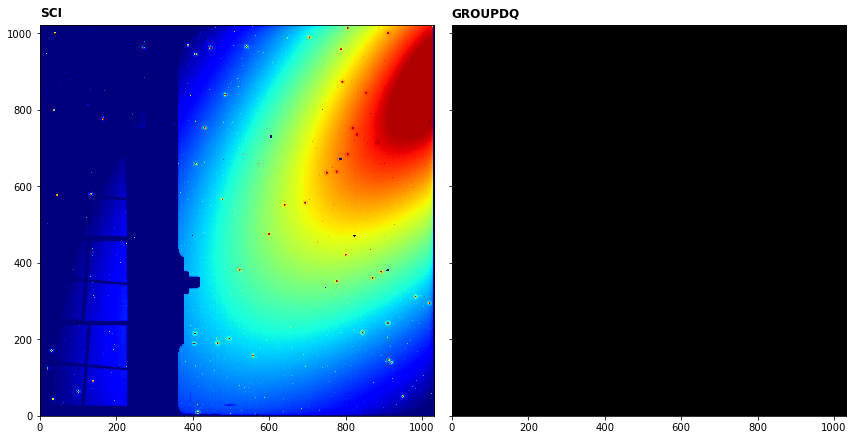

In [4]:
# plot the science and pixeldq arrays
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1.1e4,vmax=6.5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot the PIXEL_DQ frame
axs[1].imshow(dm.groupdq[0,-1,:,:], cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

In this case, it seems none of the pixels have been flagged as saturated as the `GROUPDQ` is blank.

We can also plot the ramps of a pixel at the centre of the galaxy and at the edge with the saturation limit determined for these pixels using the saturation reference file.

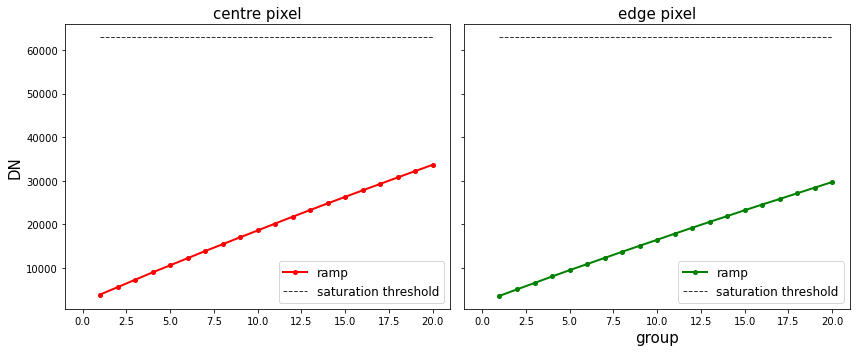

In [5]:
# using image in previous cell, select pixel to check
centre_pixel = [688,511]
edge_pixel = [800,400]

# define group numbers for integration ramps
group = range(1,dm.data[0,:,centre_pixel[0],centre_pixel[1]].shape[0]+1,1)

# get the reference file that was used in the step
ref_file = os.path.join(os.environ['CRDS_PATH'], 'references', 'jwst',
                        'miri', os.path.basename(dm.meta.ref_file.saturation.name))
ref_dm = datamodels.SaturationModel(ref_file)

# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# centre pixel
axs[0].plot(group, dm.data[0,:,centre_pixel[1],centre_pixel[0]], c='r', 
            marker='o', markersize=4, linestyle='-', linewidth=2, label='ramp')
axs[0].plot([min(group), max(group)], 
            [ref_dm.data[centre_pixel[1], centre_pixel[0]], ref_dm.data[centre_pixel[1], centre_pixel[0]]],
            c='k', markersize=0, linestyle='--', linewidth=1, alpha=0.8, label='saturation threshold')
axs[0].set_title('centre pixel',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# edge pixel
axs[1].plot(group, dm.data[0,:,edge_pixel[1],edge_pixel[0]], c='g', 
            marker='o', markersize=4, linestyle='-', linewidth=2, label='ramp')
axs[1].plot([min(group), max(group)], 
            [ref_dm.data[edge_pixel[1], edge_pixel[0]], ref_dm.data[edge_pixel[1], edge_pixel[0]]],
            c='k', markersize=0, linestyle='--', linewidth=1, alpha=0.8, label='saturation threshold')
axs[1].set_title('edge pixel',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



### Command line

To achieve the same result from the command line there are a couple of options. 

**Option 1:**
Run the `SaturationStep` class using the `strun` command:

```bash
strun jwst.saturation.SaturationStep det_image_seq1_MIRIMAGE_F1130Wexp1_dqinitstep.fits
```

**Option 2:**
If they don't already exist, collect the pipeline configuration files in your working directory using `collect_pipeline_configs` and then run the `SaturationStep` using the `strun` command with the associated `saturation.cfg` file. 

```bash
collect_pipeline_cfgs cfgs/

strun cfgs/saturation.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_dqinitstep.fits
```

This will produce the same output file ending with `_saturationstep.fits` 


A full list of the command line options are given by running the following:

```bash
strun jwst.saturation.SaturationStep -h
```

or 

```bash
strun cfgs/saturation.cfg -h
```


### Override reference file

To override the reference file for this step in Python:

```python
# set the override reference file name
my_ref = 'my_sat.fits'

dm = saturation.SaturationStep.call(my_input_file, output_use_model=True, save_results=True,
                                    override_mask=my_ref)
```

and using the command line:

```bash
strun jwst.saturation.SaturationStep det_image_seq1_MIRIMAGE_F1130Wexp1_dqinitstep.fits  --override_saturation my_sat.fits
```

or

```bash
strun cfgs/saturation.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_dqinitstep.fits --override_saturation my_sat.fits
```